## 베이즈 회귀

### 11-4-1 베이즈 정리
>p(H) : 가설 H가 맞을 사전 확률\
p(D) : 특정 자료 D가 나올 수 있는 모든 확률, 한정상수(normalizing constant)라고 함\
p(D|H) : 가설 H하에서 특정 자료 D가 나올 확률, 우도(likelihood)\
p(H|D) : D가 H가 맞을 확률, 사후확률

$ p(H|D) = \frac{p(H)p(D|H)}{p(D)} $

### 11-4-2 PyMC3

In [2]:
import warnings
warnings.simplefilter('ignore')
import pymc3 as pm
import numpy as np
np.random.seed(1000)
import matplotlib.pyplot as plt
%matplotlib inline

### 11-4-3 기초 예제

In [3]:
x = np.linspace(0,10,500)
y = 4 + 2*x+np.random.standard_normal(len(x))*2

In [4]:
reg = np.polyfit(x,y,1) #선형회귀분석

Text(0,0.5,'y')

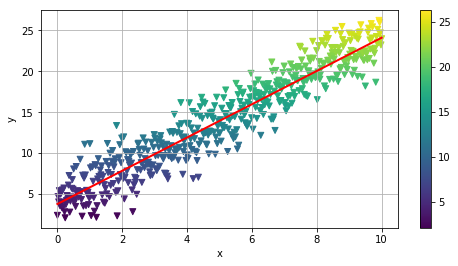

In [5]:
plt.figure(figsize = (8,4))
plt.scatter(x,y,c = y, marker = 'v')
plt.plot(x,reg[1]+reg[0]*x,lw = 2.0,c= 'r')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

In [6]:
reg #고정된 회귀 인수값

array([2.03384161, 3.77649234])

마코프 체인 몬테카를로(MCMC)방법 <구조적이고 자동화 되어있음\
find_MAP < P(H|D) 최대화하는 국지점 계산 : 시작점 찾기\
NUTS < P(D|H)에 따른 MCMC 샘플링 알고리즘 구현

In [7]:
with pm.Model() as model:
        #PyMC3 모형은 with 문에서 사용
    #사전확률 정의
    alpha = pm.Normal('alpha',mu = 0,sd =20)
    beta = pm.Normal('beta',mu = 0, sd =20)
    sigma = pm.Uniform('sigma',lower = 0, upper = 10)
    
    #선형 회귀선 정의
    y_est = alpha +beta*x
    
    #우도 정의
    likelihood = pm.Normal('y',mu = y_est,sd = sigma, observed = y)
    
    #추정 과정
    start = pm.find_MAP()
        #최적화 사용해 시작값 추정
    step = pm.NUTS(scaling = start) #pm.NUTS(), pm.slice(), pm.Met~~()
        #MCMC sampling algorithm instant 생성
    trace = pm.sample(100,step,start = start, progressbar = False)
        #NUTS 샘플링 사용한 100개 사후 샘플 생성


Optimization terminated successfully.
         Current function value: 1065.968801
         Iterations: 17
         Function evaluations: 21
         Gradient evaluations: 21


In [8]:
trace[0]

{'alpha': 3.7965131071879905,
 'beta': 2.045790789227906,
 'sigma': 2.127335022636388,
 'sigma_interval__': -1.308526596650881}

<Figure size 576x576 with 0 Axes>

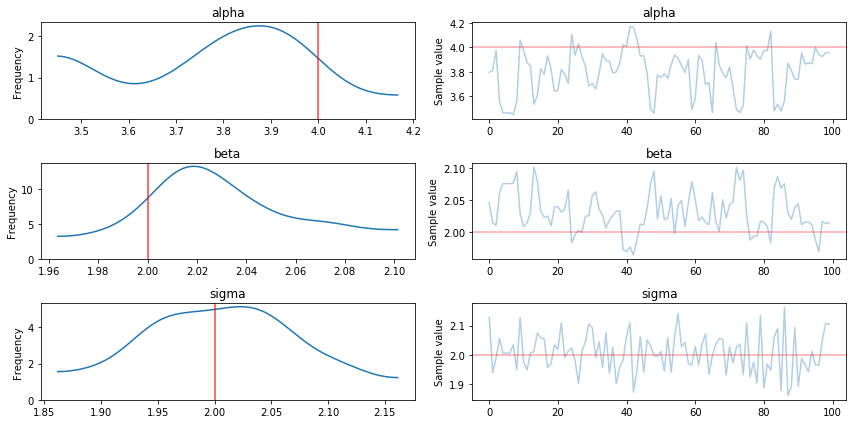

<Figure size 576x576 with 0 Axes>

In [9]:
fig = pm.traceplot(trace,lines = {'alpha':4,'beta':2,'sigma':2})
plt.figure(figsize=(8,8))


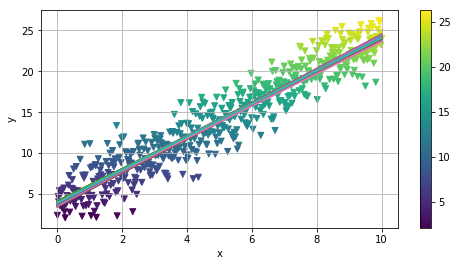

In [10]:
plt.figure(figsize = (8,4))
plt.scatter(x,y,c=y,marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x,trace['alpha'][i]+trace['beta'][i]*x)

### 11-4-4 현실 자료 적용

In [11]:
import warnings
warnings.simplefilter('ignore')
import pytz
import datetime as dt
import pandas as pd
from pandas_datareader import data as web
#import zipline

In [4]:
#GLD,GDX (금,금광회사)
#data = zipline.data.loader.load(stocks = ['GLD','GDX'])
#data1 = web.DataReader('GLD','yahoo')
#data2 = web.DataReader('GDX','yahoo')
#data = pd.concat(data1,data2)
#data = web.get_data_yahoo(['GLD','GDX'],  interval='m')
#symbols =  ['GLD','GDX']
#for sym in symbols:
#    data[sym] = web.DataReader(sym,data_source = 'yahoo',start = '2006-05-20', end = '2014-03-15')['Close']
#data.info()

In [12]:
data = pd.DataFrame()
symbols = ['GLD','GDX']
for sym in symbols:
    data[sym] = web.DataReader(sym,data_source='yahoo',start = '2006-05-20', end = '2014-03-15')['Close']
data.columns = symbols
data = data.dropna()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1967 entries, 2006-05-22 to 2014-03-14
Data columns (total 2 columns):
GLD    1967 non-null float64
GDX    1967 non-null float64
dtypes: float64(2)
memory usage: 46.1 KB


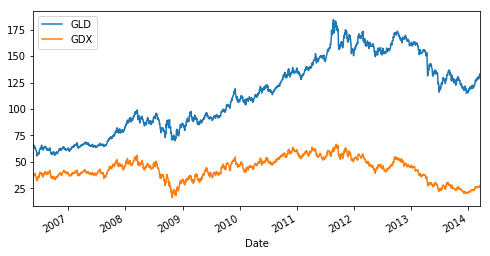

In [14]:
data.plot(figsize =(8,4))

In [15]:
data.iloc[-1]/data.iloc[0] -1  #퍼센테이지로 변환

GLD    1.038285
GDX   -0.255171
dtype: float64

In [16]:
data.corr() #강한 양의 상관관계

,GLD,GDX
GLD,1.000000,0.428004
GDX,0.428004,1.000000


In [17]:
data.index #timestamp로 구성됨

DatetimeIndex(['2006-05-22', '2006-05-23', '2006-05-24', '2006-05-25',
               '2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05',
               ...
               '2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14'],
              dtype='datetime64[ns]', name='Date', length=1967, freq=None)

In [5]:
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index)
mpl_dates  #matplotlib에서 날짜 정보 사용하기 위해

array([13290., 13291., 13292., ..., 16141., 16142., 16143.])

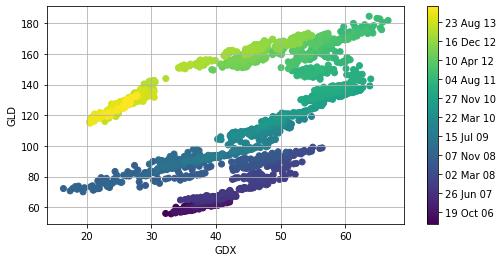

In [11]:
plt.figure(figsize = (8,4))
plt.scatter(data['GDX'],data['GLD'],c = mpl_dates,marker ='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks = mpl.dates.DayLocator(interval = 250),
            format = mpl.dates.DateFormatter('%d %b %y'))

In [13]:
#이 두 시계열의 베이즈 회귀분석
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu = 0,sd = 20)
    beta = pm.Normal('beta',mu = 0, sd =20)
    sigma = pm.Uniform('sigma',lower = 0, upper = 50)
    y_est = alpha + beta*data['GDX'].values
    likelihood = pm.Normal('GLD',mu = y_est,sd = sigma,observed = data['GLD'].values)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(100,step,start =start, progressbsr = False)

Optimization terminated successfully.
         Current function value: 9632.370119
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [27:24<00:00,  2.74s/it]


<Figure size 576x576 with 0 Axes>

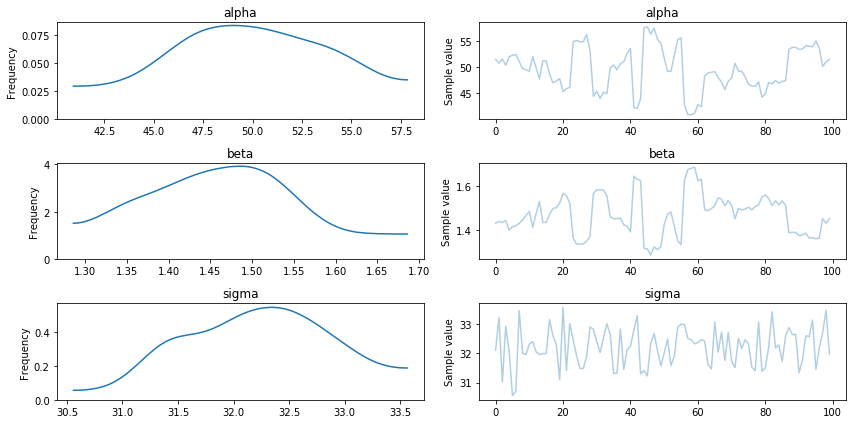

<Figure size 576x576 with 0 Axes>

In [14]:
fig = pm.traceplot(trace)
plt.figure(figsize=(8,8))

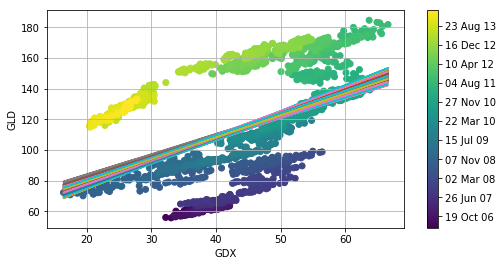

In [15]:
#스캐터 플롯에 회귀선 추가
plt.figure(figsize = (8,4))
plt.scatter(data['GDX'],data['GLD'],c = mpl_dates,marker ='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'],trace['alpha'][i]+trace['beta'][i]*data['GDX'])
plt.colorbar(ticks = mpl.dates.DayLocator(interval = 250),
            format = mpl.dates.DateFormatter('%d %b %y'))

시간에 따른 변화 고려 X. > 최근과 과거의 자료 동일하게 다룸.

In [16]:
#새로운 모형 정의 > 모수 랜덤워크 설정, 분산값은 로그공간 변환 사용

In [7]:
#from pymc3.distributions.timeseries import Exponential
from pymc3 import Exponential
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = Exponential('sigma_alpha',1./.02,testval=.1)
    sigma_beta = Exponential('slgma_beta',1./.02,testval=.1)

In [8]:
from pymc3.distributions.timeseries import GaussianRandomWalk
#단순화 하기 위해 자료 50개씩 같은 계수값 적용
subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha',sigma_alpha**-2,shape = int(len(data)/subsample_alpha))  #shape int형태여야함
    beta = GaussianRandomWalk('beta',sigma_beta**-2,shape = int(len(data)/subsample_beta))
    #계수 자료의 길이 = 가격 자료 길이
    alpha_r = np.repeat(alpha,subsample_alpha)
    beta_r = np.repeat(beta,subsample_beta)

In [6]:
len(data.dropna().GDX.values) #시계열 자료

1967

In [10]:
#50개씩 나눠 적용하기 위해 1950개만 사용
with model_randomwalk:
    #regression def
    regression = alpha_r + beta_r*data.GDX.values[:1950]
    
    #price (정규분포 가정)
    sd = pm.Uniform('sd',0,20)
    likelihood = pm.Normal('GLD', mu = regression, sd = sd, observed = data.GLD.values[:1950])

In [ ]:
import scipy.optimize as sco
from pymc3.distributions.timeseries import GaussianRandomWalk
from pymc3 import Exponential
model_randomwalk = pm.Model()

subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    sigma_alpha = Exponential('sigma_alpha',1./.02,testval=.1)
    sigma_beta = Exponential('slgma_beta',1./.02,testval=.1)
    
    alpha = GaussianRandomWalk('alpha',sigma_alpha**(-2),shape = int(len(data)/subsample_alpha))  #shape int형태여야함
    beta = GaussianRandomWalk('beta',sigma_beta**(-2),shape = int(len(data)/subsample_beta))
    #계수 자료의 길이 = 가격 자료 길이
    alpha_r = np.repeat(alpha,subsample_alpha)
    beta_r = np.repeat(beta,subsample_beta)
    
     #regression def
    regression = alpha_r + beta_r*data.GDX.values[:1950]
    
    #price (정규분포 가정)
    sd = pm.Uniform('sd',0,20)
    likelihood = pm.Normal('GLD', mu = regression, sd = sd, observed = data.GLD.values[:1950])
    
    #최적화 사용 > 랜덤워크 모수 분포 초기값 설정
    start = pm.find_MAP(vars = [alpha,beta],fmin = sco.fmin_bfgs)
    #sampling
    step = pm.NUTS(scaling = start)
    trace_rw = pm.sample(100,step,start = start, progressbar=False)  #step 39개임 (∵1950/50) 그래서 계산 부담 多

Optimization terminated successfully.
         Current function value: 6273.236120
         Iterations: 94
         Function evaluations: 118
         Gradient evaluations: 118


In [33]:
np.shape(trace_rw['alpha'])

NameError: name 'trace_rw' is not defined

IndexError: index 45 is out of bounds for axis 0 with size 0

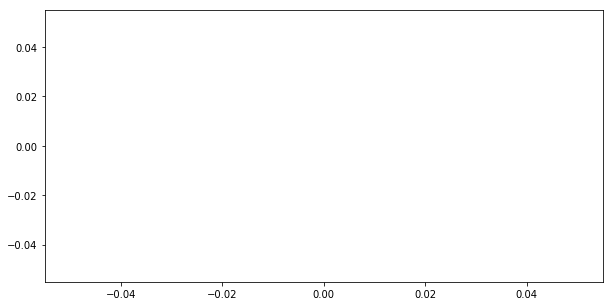

In [71]:
part_dates = np.linspace(min(mpl_dates),max(mpl_dates),39)
fig, ax1 = plt.subplots(figsize = (10,5))
plt.plot(part_dates,np.mean(trace_rw['alpha'],axis = 0),
        'b',lw = 2.5, label = 'alpha')
for i in range(45,55):
    plt.plot(part_dates,trace_rw['alpha'][i],'b-.',lw = 0.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.axis('tonight')
plt.grid(True)
plt.legend(loc = 2)

ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b %y'))   #%m 하면 숫자로 달 표시
ax2 = ax1.twinx()
plt.plot(part_dates,np.mean(trace_rw['beta'],axis = 0),
        'r', lw =2.5, label = 'beta')
for i in range(45,55):
    plt.plot(part_dates,trace_rw['beta'][i], 'r-.',lw = 0.75)   #linestyle : -.
plt.ylabel('beta')
plt.legend(loc = 4)
fig.autofmt_xdate()
#평균(alpha,beta)추정값이 시간에 따라 변하는 모습